# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Learning rate = 0.001
- Hidden unit = 200
- Epochs = 100
- N = 100
- Data Length = 100K
- Data = [single_Ctype4_error_rate]
- Deduplication
- Random split

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
rnnis = ["lstm", "gru"]

# Prepare dataset

In [ ]:
for rnn in rnnis:
    print("rnn : %s" % rnn)
    train_path = "data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_train.txt"
    dev_path = "data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_test.txt"
    config_path = "models/config.json"
    max_len = 104
    src = fields.SourceField()
    tgt = fields.TargetField()
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()
        
    '''
    {
        "max_len": 102,
        "embedding_size": 5,
        "hidden_size": 200,
        "input_dropout_p": 0,
        "dropout_p": 0,
        "n_layers": 1,
        "bidirectional": false,
        "rnn_cell": "lstm",
        "variable_lengths": false,
        "embedding": null,
        "update_embedding": true,
        "get_context_vector": false,
        "use_attention": true,
        "attn_layers": 1,
        "hard_attn": false,
        "position_embedding": null
    }

    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = None
    
    print("Train_path : %s" % train_path)
    print("Dev_path = %s" % dev_path)
    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
    
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = Trainer(loss=loss, batch_size=32,
                checkpoint_every=50,
                print_every=100,
                hidden_size=config["hidden_size"],
                path="palindrome_rand_error_rate_5_hard_attn",
                file_name=config["rnn_cell"])

    seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

    character_accuracy.append(character_accuracy_list)
    sentence_accuracy.append(sentence_accuracy_list)
    f1_score.append(f1_score_list)

rnn : lstm


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2019-08-19 02:19:47,478 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Train_path : data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_train.txt
Dev_path = data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_test.txt
{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": null
}


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-08-19 02:23:59,072 INFO   Finished epoch 1: Train loss: 1.6065, Dev loss: 1.3909, Accuracy(character): 0.9087, Accuracy(sentence): 0.0876, F1 Score: 0.0000
2019-08-19 02:27:53,702 INFO   Finished epoch 2: Train loss: 1.3463, Dev loss: 1.3216, Accuracy(character): 0.9337, Accuracy(sentence): 0.3233, F1 Score: 0.4546
2019-08-19 02:31:45,347 INFO   Finished epoch 3: Train loss: 1.3789, Dev loss: 1.2320, Accuracy(character): 0.9561, Accuracy(sentence): 0.3198, F1 Score: 0.6378
2019-08-19 02:35:36,302 INFO   Finished epoch 4: Train loss: 1.4047, Dev loss: 1.0403, Accuracy(character): 0.9907, Accuracy(sentence): 0.8200, F1 Score: 0.9215
2019-08-19 02:39:28,010 INFO   Finished epoch 5: Train loss: 1.1513, Dev loss: 1.0305, Accuracy(character): 0.9928, Accur

In [ ]:
for rnn in rnnis:
    print("rnn : %s" % rnn)
    train_path = "data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_train.txt"
    dev_path = "data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_test.txt"
    config_path = "models/config.json"
    max_len = 104
    src = fields.SourceField()
    tgt = fields.TargetField()
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()
        
    '''
    {
        "max_len": 102,
        "embedding_size": 5,
        "hidden_size": 200,
        "input_dropout_p": 0,
        "dropout_p": 0,
        "n_layers": 1,
        "bidirectional": false,
        "rnn_cell": "lstm",
        "variable_lengths": false,
        "embedding": null,
        "update_embedding": true,
        "get_context_vector": false,
        "use_attention": true,
        "attn_layers": 1,
        "hard_attn": false,
        "position_embedding": null
    }

    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = "length"
    
    print("Train_path : %s" % train_path)
    print("Dev_path = %s" % dev_path)
    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
    
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = Trainer(loss=loss, batch_size=32,
                checkpoint_every=50,
                print_every=100,
                hidden_size=config["hidden_size"],
                path="palindrome_rand_error_rate_5_hard_attn",
                file_name=config["rnn_cell"] + "_lenemb")

    seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

    character_accuracy.append(character_accuracy_list)
    sentence_accuracy.append(sentence_accuracy_list)
    f1_score.append(f1_score_list)

rnn : lstm


2019-08-19 16:05:20,225 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Train_path : data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_train.txt
Dev_path = data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_test.txt
{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": "length"
}


2019-08-19 16:10:03,046 INFO   Finished epoch 1: Train loss: 1.4710, Dev loss: 1.2688, Accuracy(character): 0.9370, Accuracy(sentence): 0.2812, F1 Score: 0.0562
2019-08-19 16:14:23,271 INFO   Finished epoch 2: Train loss: 1.1245, Dev loss: 1.0210, Accuracy(character): 0.9950, Accuracy(sentence): 0.8612, F1 Score: 0.9596
2019-08-19 16:18:45,767 INFO   Finished epoch 3: Train loss: 1.0281, Dev loss: 1.0124, Accuracy(character): 0.9959, Accuracy(sentence): 0.8929, F1 Score: 0.9667
2019-08-19 16:23:23,459 INFO   Finished epoch 4: Train loss: 1.0380, Dev loss: 1.0015, Accuracy(character): 0.9996, Accuracy(sentence): 0.9870, F1 Score: 0.9967
2019-08-19 16:27:56,644 INFO   Finished epoch 5: Train loss: 1.0254, Dev loss: 1.0031, Accuracy(character): 0.9996, Accuracy(sentence): 0.9832, F1 Score: 0.9965
2019-08-19 16:32:09,525 INFO   Finished epoch 6: Train loss: 1.0076, Dev loss: 1.0003, Accuracy(character): 0.9999, Accuracy(sentence): 0.9975, F1 Score: 0.9995
2019-08-19 16:36:26,317 INFO   Fin

2019-08-19 20:03:23,875 INFO   Finished epoch 52: Train loss: 1.0006, Dev loss: 1.0004, Accuracy(character): 1.0000, Accuracy(sentence): 0.9998, F1 Score: 1.0000
2019-08-19 20:07:36,129 INFO   Finished epoch 53: Train loss: 1.0009, Dev loss: 1.0008, Accuracy(character): 0.9999, Accuracy(sentence): 0.9948, F1 Score: 0.9990
2019-08-19 20:11:50,256 INFO   Finished epoch 54: Train loss: 1.0006, Dev loss: 1.0001, Accuracy(character): 1.0000, Accuracy(sentence): 0.9997, F1 Score: 0.9999
2019-08-19 20:16:31,266 INFO   Finished epoch 55: Train loss: 1.0004, Dev loss: 1.0001, Accuracy(character): 1.0000, Accuracy(sentence): 0.9998, F1 Score: 1.0000
2019-08-19 20:21:14,593 INFO   Finished epoch 56: Train loss: 1.0006, Dev loss: 1.0007, Accuracy(character): 0.9999, Accuracy(sentence): 0.9975, F1 Score: 0.9995
2019-08-19 20:25:47,344 INFO   Finished epoch 57: Train loss: 1.0007, Dev loss: 1.0003, Accuracy(character): 1.0000, Accuracy(sentence): 0.9999, F1 Score: 1.0000
2019-08-19 20:30:23,235 INFO

(0, 1)

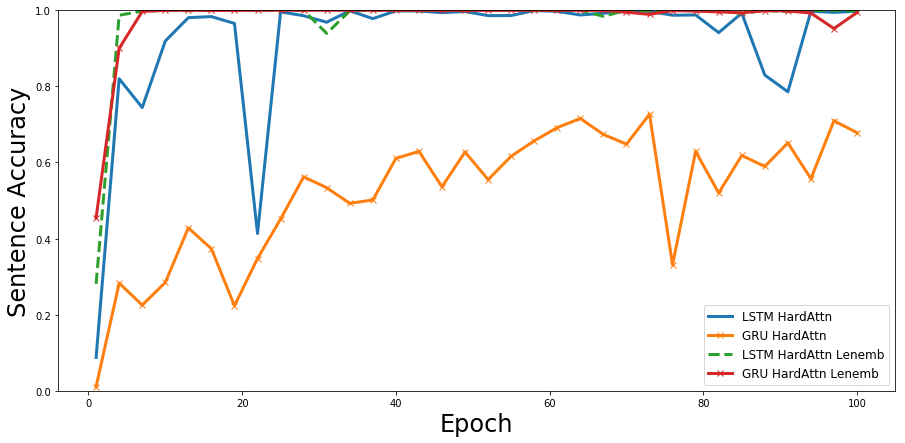

In [15]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], sentence_accuracy[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], sentence_accuracy[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], sentence_accuracy[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], sentence_accuracy[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_sentence_accuracy.png')

(0, 1.02)

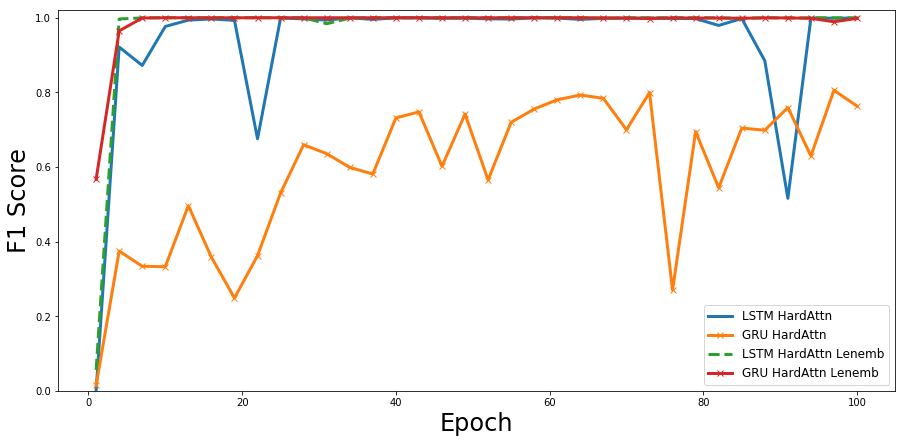

In [24]:
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], f1_score[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], f1_score[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], f1_score[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], f1_score[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_f1_score.png')

In [17]:
error_rate_list = []
for i in range(len(character_accuracy)):
    error_rate = []
    for j in character_accuracy[i]:
        error_rate.append(1 - j)
    error_rate_list.append(error_rate)

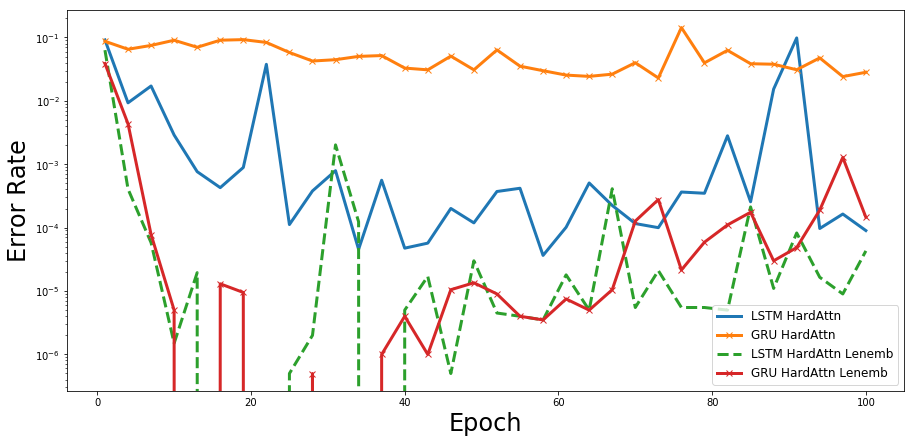

In [18]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], error_rate_list[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], error_rate_list[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], error_rate_list[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], error_rate_list[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Error Rate', fontsize=24)
plt.yscale('log')
#plt.ylim([0, 1])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_error_rate.png')

In [19]:
print(len(character_accuracy))
for i in character_accuracy:
    print(i)

4
[0.9086561520612568, 0.9337284703034026, 0.9561064915406852, 0.9907000884471296, 0.9927960959616456, 0.9953438120413737, 0.9828669832947603, 0.9938037151783052, 0.9939971621135174, 0.9971132532090753, 0.999367308863958, 0.9927946002379198, 0.9992376794743827, 0.9996225790465061, 0.9969178119755618, 0.9995732201635524, 0.9998643877155213, 0.9998504276274133, 0.9991120386814099, 0.9957381845304275, 0.9997078352988805, 0.9623301979640209, 0.9999197294933785, 0.9999311967086101, 0.9998883192951352, 0.9974846912676657, 0.9997915958275291, 0.9996215818973555, 0.9999267095374325, 0.9991504289237071, 0.9992092607235913, 0.9996514963718728, 0.9996704422057338, 0.9999546297136487, 0.9999675926526062, 0.9914305001999284, 0.9994415964756761, 0.9999755698458108, 0.8887071861547835, 0.9999526354153475, 0.9996898866141701, 0.9999601140339769, 0.999943162498417, 0.9990960842950006, 0.9999411682001159, 0.9997995730207337, 0.9999182337696526, 0.9883587822415714, 0.9998813392510811, 0.9998424504342086,

In [20]:
print(len(sentence_accuracy))
for i in sentence_accuracy:
    print(i)

4
[0.08762, 0.32328, 0.31982, 0.82004, 0.82502, 0.87946, 0.74434, 0.83856, 0.8367, 0.91926, 0.9773, 0.85282, 0.98062, 0.98616, 0.88704, 0.9834, 0.99486, 0.99486, 0.96534, 0.88924, 0.98922, 0.41326, 0.99712, 0.99756, 0.9959, 0.91642, 0.99184, 0.98564, 0.99724, 0.98326, 0.96858, 0.98698, 0.98832, 0.99864, 0.99912, 0.9076, 0.97806, 0.99942, 0.4465, 0.99844, 0.98932, 0.9987, 0.99808, 0.97294, 0.99796, 0.99378, 0.99728, 0.72008, 0.99678, 0.9961, 0.9943, 0.98596, 0.97408, 0.99914, 0.98616, 0.99686, 0.89444, 0.99928, 0.99326, 0.9984, 0.99708, 0.99572, 0.94952, 0.98766, 0.99684, 0.99668, 0.99224, 0.99626, 0.99446, 0.99686, 0.9967, 0.99646, 0.99724, 0.97744, 0.9858, 0.987, 0.91572, 0.97182, 0.98772, 0.9797, 0.99162, 0.9412, 0.94198, 0.96334, 0.99258, 0.9944, 0.8025, 0.82982, 0.83954, 0.7891, 0.78574, 0.99442, 0.99658, 0.99722, 0.9953, 0.99556, 0.99444, 0.99354, 0.9902, 0.99746]
[0.01106, 0.06604, 0.23646, 0.28276, 0.2023, 0.48414, 0.22534, 0.2461, 0.41396, 0.28468, 0.56394, 0.48756, 0.42802, 0.

In [21]:
print(len(f1_score))
for i in f1_score:
    print(i)

4
[3.1279813572311106e-05, 0.45456284290532034, 0.6377761311536145, 0.9214662763987284, 0.9401786482907892, 0.962177307999774, 0.8720880876881977, 0.9499322130087966, 0.9507127091031103, 0.9766081871345029, 0.9949849784986353, 0.9434404522660256, 0.993641923445163, 0.9970321988779595, 0.9744881276761386, 0.9966220315564098, 0.9989394716142338, 0.9988186604705018, 0.9930201613844514, 0.9645980455372071, 0.9976835304090346, 0.6755053267583352, 0.9993511011734905, 0.9994565323636931, 0.999115757514105, 0.9798771463270813, 0.9983517685289338, 0.9970401592136284, 0.9994327717121296, 0.9927968525631298, 0.9937684512264467, 0.9972022241732514, 0.9973487643836365, 0.9996441239387267, 0.999753649313933, 0.9327681133197199, 0.9956141556366149, 0.9998162217538701, 0.4527187088091881, 0.9996323845726666, 0.9974475215120695, 0.9996832460630614, 0.9995347000379279, 0.9921612192792687, 0.9995307110509727, 0.9983675318487507, 0.9993314279682057, 0.9092900446948801, 0.9990463385654431, 0.99873421677709

In [22]:
print(len(error_rate_list))
for i in error_rate_list:
    print(i)

4
[0.09134384793874317, 0.06627152969659744, 0.043893508459314834, 0.009299911552870355, 0.0072039040383543584, 0.004656187958626323, 0.0171330167052397, 0.006196284821694764, 0.006002837886482593, 0.00288674679092471, 0.0006326911360420295, 0.0072053997620802335, 0.0007623205256173105, 0.00037742095349391214, 0.0030821880244381594, 0.0004267798364475661, 0.00013561228447867002, 0.00014957237258672595, 0.0008879613185901469, 0.004261815469572494, 0.00029216470111947945, 0.03766980203597914, 8.027050662151591e-05, 6.880329138991836e-05, 0.00011168070486478054, 0.002515308732334298, 0.0002084041724709218, 0.0003784181026444955, 7.329046256754346e-05, 0.0008495710762929098, 0.000790739276408714, 0.0003485036281272169, 0.0003295577942662442, 4.5370286351320566e-05, 3.2407347393847985e-05, 0.0085694998000716, 0.0005584035243239027, 2.4430154189181152e-05, 0.1112928138452165, 4.7364584652487274e-05, 0.0003101133858298688, 3.988596602311212e-05, 5.683750158302914e-05, 0.0009039157049993696, 5